Sophie Lohmann w/PCN 8/2019. Python 3.7.


In [1]:
import scipy as sc
from scipy import ndimage
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
# Load data
#x=np.load('MBL/2dImages.npz') #first version of dataset
#x=np.load('MBL/2dPrepChinese6-3-1-1500NewRotation.npz')
x=np.load('MBL/2dImagesLOW.npz') #ultra-low SNR in first set, and 3000 images

# Extract variables
sd=x['shiftSD']
noiselevels = x['noiselevels']
smp = x['samples']
print(smp.shape); print(noiselevels)

# reference image
ref = plt.imread('MBL/test2Dblur.tif')

(3000, 85, 85, 3)
[8 3 1]


In [3]:
def maxlikelihood2d(X,A,sigma,sigmaq,Nsteps=3,xiq0=0,xiq1=0,angles=60):
    N=X[:,0,0].size
    #N=100 # for debugging
    print('N=',N)
    start=timer()
    M=X[0,0,:].size
    s=int((M-1)/2)
    
    fig, axs = plt.subplots(int((Nsteps-1)/3)+1,3, figsize=(15, 6))
    axs = axs.ravel()
    
    for ns in range(Nsteps): 
        print('iteration #', ns)
        Apresum=np.zeros((angles,M,M)) # PN
        RA=np.array([ndimage.rotate(A,a*360/angles,reshape=False) for a in range(angles)])
        exponent1=np.multiply(-1/(2*np.square(sigma)), \
            [[[np.sum(np.square(RA[a,np.max([s-i,0]):np.min([M+s-i,M]), \
               np.max([s-j,0]):np.min([M+s-j,M])])) for j in range(M)] \
            for i in range(M)] for a in range(angles)])
        exponent3=np.multiply(-1/(2*np.square(sigmaq)), \
            [[[np.square(-s+i-xiq0)+np.square(-s+j-xiq1) for j in range(M)] \
            for i in range(M)] for a in range(angles)])    
        for n in range(N):         
            exponent2=np.multiply(1/(np.square(sigma)), \
                [signal.correlate(RA[a,:,:], X[n,:,:], mode='same') for a in range(angles)])
            exponent=exponent1+exponent2 # PN removed +exponent3
            K=np.amax(exponent)
            gammai=np.exp(exponent-K+exponent3) #PN added +exponent3
            U=1/np.sum(gammai)
            gammaXi=np.array([signal.convolve(X[n,:,:],gammai[a,:,:],mode='same') \
                              for a in range(angles)])
            Apresum+=U.reshape((1,1,1))*gammaXi
        
        A=np.zeros((M,M))
        for a in range(angles):
            A+=1/N*ndimage.rotate(Apresum[a,:,:],(angles-a)*360/angles,reshape=False) 
        axs[ns].imshow(A,'gray')
        axs[ns].set_title('Step {}'.format(ns))
    print('time: ',timer()-start)
    return A

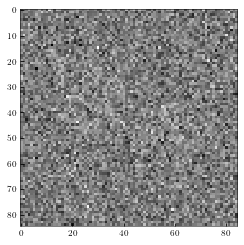

In [4]:
plt.imshow(smp[0,:,:,0],'gray')

N= 3000
iteration # 0
iteration # 1
iteration # 2
iteration # 3
iteration # 4
iteration # 5
iteration # 6
iteration # 7
iteration # 8
time:  4505.737014106


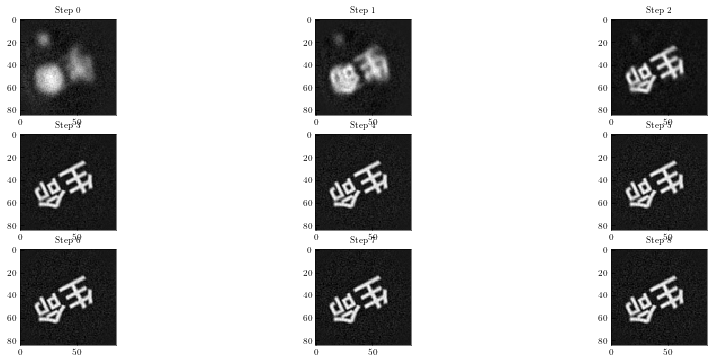

In [7]:
qq=0; A=maxlikelihood2d(smp[:,:,:,qq],ref,sigma=noiselevels[qq],sigmaq=6,Nsteps=9)
plt.imsave('out'+str(qq)+'.pdf', A, cmap='gray')

N= 3000
iteration # 0
iteration # 1
iteration # 2
iteration # 3
iteration # 4
iteration # 5
iteration # 6
iteration # 7
iteration # 8
time:  3369.7983142330004


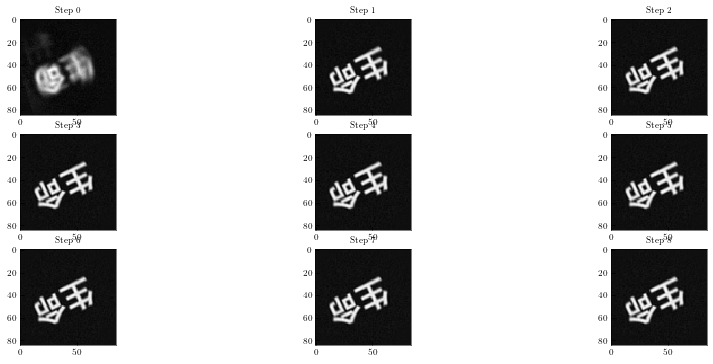

In [9]:
qq=1; A=maxlikelihood2d(smp[:,:,:,qq],ref,sigma=noiselevels[qq],sigmaq=6,Nsteps=9)
plt.imsave('out'+str(qq)+'.pdf', A, cmap='gray')

In [ ]:
#qq=1; A=maxlikelihood2d(smp[:,:,:,qq],ref,sigma=noiselevels[qq],sigmaq=6,Nsteps=6,angles=120)

In [ ]:
#qq=2; A=maxlikelihood2d(smp[:,:,:,qq],ref,sigma=noiselevels[qq],sigmaq=6,Nsteps=9)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
X,Y = np.meshgrid(range(85),range(85))
ax = Axes3D( plt.figure() ); ax.plot_surface(X,Y,A)
plt.show()